<a href="https://colab.research.google.com/github/yumi-kim/big_data_class/blob/master/%EC%BD%94%EB%94%A911%EC%9D%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
cd /content/gdrive/My\ Drive
cd analysis/경상대/2019/8.\ 강의
cd 2019바이오빅데이터/2019바이오빅데이터\ 수업자료/

/content/gdrive/My Drive


In [0]:
import pandas as pd
import numpy as np
from collections import Counter

In [0]:
! cp ../ipynb/glyma.Wm82.gnm2.div.S3DM.SNPdata.vcf.gz.gt_sub.filterbyMAF.pkl . 

In [0]:
df_soy = pd.read_pickle('./glyma.Wm82.gnm2.div.S3DM.SNPdata.vcf.gz.gt_sub.filterbyMAF.pkl')

In [0]:
df_soy.head()

,56-1,56-2,2,3,6,7,8,9,55-1,55-2,5-1,5-2,54-1,54-2,403,406,407,243-1,243-2,410,419,420,421,300,301,422,302,423,424,303,304,426,305,306,428,307,429,308,61-1,430,...,87,89,190,191,192,193,194,195,196,197,198,199,91,92,94,95,96,97,98,99,238-1,238-2,21-Emgopa,205-2,205-1,229-1,165B,165A,229-2,58-2,58-1,425-2,425-1,69-2,69-1,34-2,34-1,57-1,57-2,maf
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S1_284820,CC,CC,GG,GG,GG,GG,CC,GC,CC,CC,CC,CC,GG,GG,GG,GG,GG,GG,NN,GG,GG,GG,NN,GG,GG,GG,GG,CC,GG,GG,GG,GG,GG,GG,CC,NN,GG,NN,GC,CC,...,CG,GG,GG,GG,GG,GG,GG,GG,CC,GG,CC,NN,GG,CG,GG,CC,CC,GG,CC,GG,GG,GG,GG,GG,NN,GG,GG,GG,GG,GG,GG,GG,GG,NN,CC,GG,GG,GG,GG,0.239305
S1_377146,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,TT,TT,NN,CC,TT,NN,CC,CC,CC,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,...,CC,CC,TT,CC,CC,TT,CC,CC,CC,CC,CC,NN,CC,CT,TT,CC,CC,TT,CC,CC,NN,CC,NN,TT,TT,CC,CC,CC,CC,CC,CC,TT,TT,NN,TT,CC,CC,CC,CC,0.106952
S1_702173,AA,AA,AA,AA,NN,AA,NN,NN,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,NN,AA,AA,TT,TT,AA,AA,TT,NN,AA,AA,NN,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,...,AA,NN,TT,AA,AA,TT,NN,AA,AA,AA,NN,NN,AA,TT,TT,AA,NN,TT,AA,AT,AA,NN,AA,TT,TT,AA,TT,TT,AA,AA,AA,TT,TT,NN,TT,AA,AA,AA,AA,0.140374
S1_1425419,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,TT,TT,CC,CT,TT,CC,NN,CC,CC,CC,CC,...,CC,TT,CC,CC,TT,CC,CC,CC,NN,CC,CC,NN,CC,CC,CC,NN,CC,CC,TT,TC,NN,CC,CC,CC,CC,TT,TT,TT,TT,CC,CC,CC,CC,TC,TC,CC,CC,CC,CC,0.176471
S1_1425452,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,NN,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,CC,TT,CC,NN,CC,CC,CC,CC,...,CC,TT,CC,CC,TT,CC,CC,CC,NN,CC,CC,NN,CC,CC,CC,NN,CC,CC,TT,TC,NN,CC,CC,CC,CC,CC,TT,TT,CC,CC,CC,CC,CC,TC,TC,CC,CC,CC,CC,0.128342


In [0]:
# Linkage Disequilibrium 
#-  Observation 
#-  Observe gamete frequency 

#-  D = g11 * g22 - g12 * g21 

#-  g11 : A1B1 frequency  -  non-recombinant
#-  g22 : A2B2 frequency  -  non-recombinant
#-  g12 : A1B2 frequency  -  recombinant
#-  g21 : A2B1 frequency  -  recombinant 

#                 HC1            HC2
#              Allele 1       Allele2
#    locus A :    A1             A2            
#    locus B :    B1             B2
# 

In [0]:
def get_D(locusA,locusB):
  data    = df_soy.loc[[locusA,locusB]].values[:,:-1]
  gamete1 = [x[0]+y[0] for x,y in data.T]
  gamete2 = [x[0]+y[1] for x,y in data.T]
  gamete3 = [x[1]+y[0] for x,y in data.T]
  gamete4 = [x[1]+y[1] for x,y in data.T]
  gametes = gamete1 + gamete2 + gamete3 + gamete4

  dicG2C = dict(Counter(gametes)) # gamete 2 count
  G2C    = list(dicG2C.items())
  G2C.sort(key = lambda x : x[1],reverse=True)

  major_gamete   = G2C[0][0]

  gamete_set     = np.array(list(dicG2C.keys()))
  number_of_true = [np.sum(np.array(list(major_gamete)) == np.array(list(x))) for x in gamete_set]
  number_of_true = np.array(number_of_true)

  m1 = number_of_true == 0
  m2 = gamete_set != 'NN'

  alternative_gamete = gamete_set[m1&m2][0]

  g11 = dicG2C[major_gamete] / len(gametes)
  g22 = dicG2C[alternative_gamete] / len(gametes)
  try:
    g12 = dicG2C[major_gamete[0] + alternative_gamete[1]] / len(gametes)
  except KeyError:
    g12 = 0 
  try:
    g21 = dicG2C[alternative_gamete[0] + major_gamete[1]] / len(gametes)
  except KeyError:
    g21 = 0 
  D   = g11 * g22 - g12 * g21
  return D

In [0]:
get_D('S1_1425419','S1_1425452')

0.09022634333266608

In [0]:
from itertools import combinations
from tqdm import tqdm_notebook 

df_D = pd.DataFrame()
for x,y in tqdm_notebook([*combinations(df_soy.index[0:100],2)]):
  D = get_D(x,y)
  df_D.at[x,y] = D

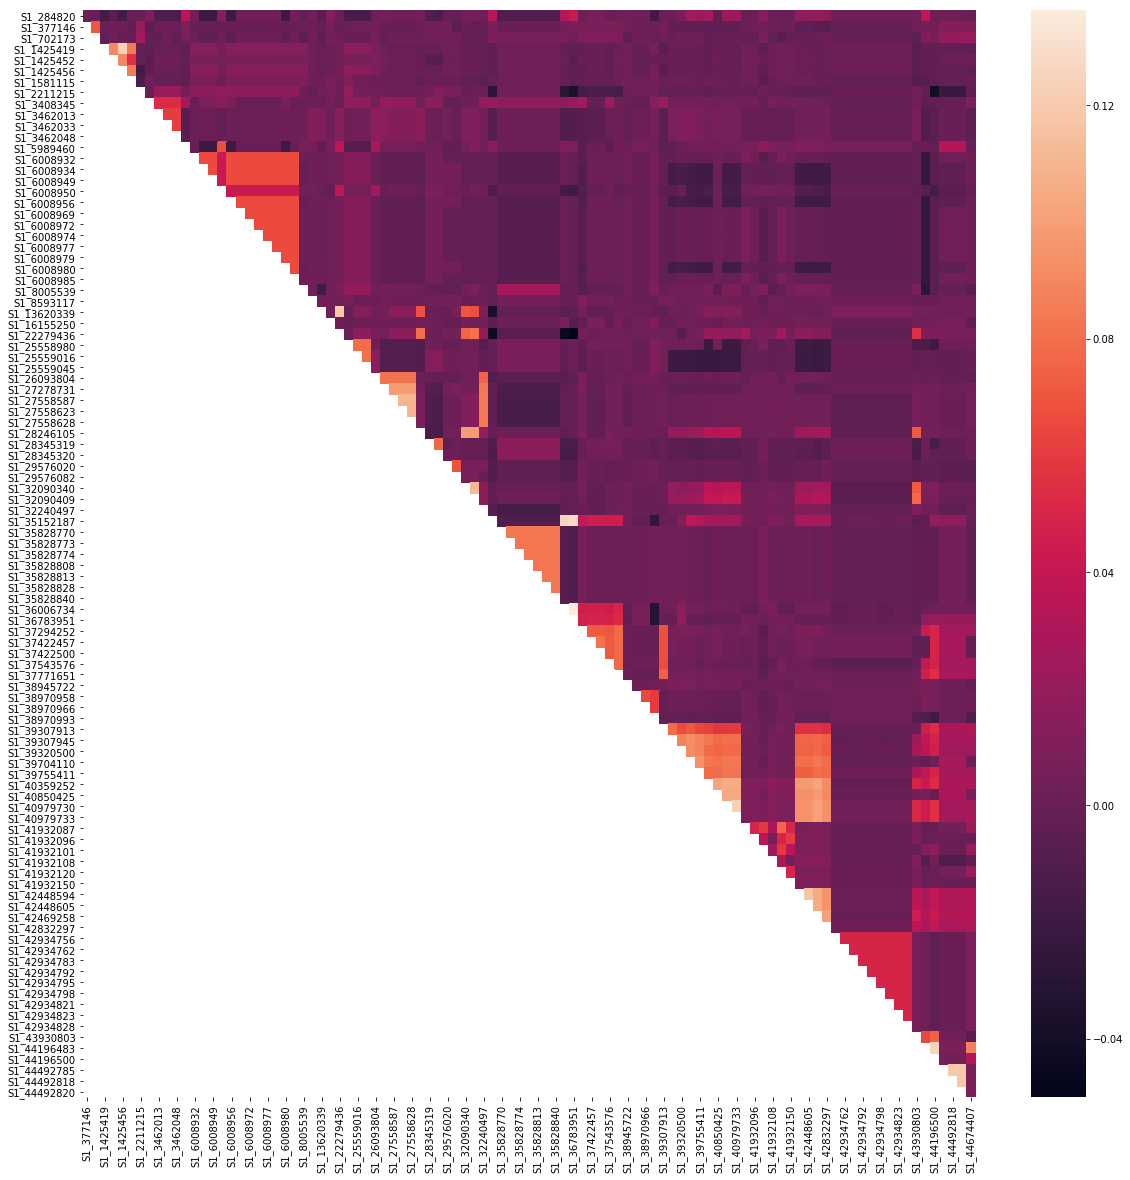

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sb.heatmap(df_D)
plt.savefig('./LD.png',dpi=300,bbox_inches='tight')